In [725]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,random_split,Dataset,Subset
import torchvision.transforms as transforms
import torchvision.models as models
from d2l import torch as d2l
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

In [726]:
# train = pd.read_csv('C:/Users/MJ/Desktop/FunctionApproximation/train.csv')
# test =pd.read_csv('C:/Users/MJ/Desktop/FunctionApproximation/test.csv')
# val_size = int(0.2 * len(train))
# train_size=len(train)-val_size
# train, valid = random_split(train,[train_size, val_size])

In [727]:
cuda = True if torch.cuda.is_available() else False

In [728]:
train=pd.read_csv("C:/Users/MJ/Desktop/FunctionApproximation/train.csv")
test=pd.read_csv("C:/Users/MJ/Desktop/FunctionApproximation/test.csv")
test_x=torch.tensor(test.drop(['id'],axis=1).values,dtype=torch.float32)

In [762]:
class FADataset(Dataset):
    def __init__(self, data,train=True):
        super().__init__()

        if(train):
            self.x=data.drop(['id','y'],axis=1).values
            self.x=torch.tensor(self.x,dtype=torch.float32)
            self.y=torch.tensor(data['y'].values,dtype=torch.float32)
        else:
            self.x=data.drop(['id'],axis=1).values
            self.x=torch.tensor(self.x,dtype=torch.float32)
        
        self.flag= ["F"] * len(self.x)
    def __len__(self):
        return len(self.x)
    def __getitem__(self, idx):
        data=self.x[idx]
        target=self.y[idx]
        return data,target,idx

    def update_flag(self, idx):
        self.flag[idx] = "T"
            

In [763]:
batch_size=96
dataset=FADataset(train,train=True)
trainset, validset = random_split(dataset, [0.9, 0.1])
train_dl= DataLoader(trainset, shuffle=True, batch_size=batch_size)
valid_dl= DataLoader(validset, shuffle=True, batch_size=batch_size)
testset=FADataset(test,train=False)
test_dl=DataLoader(testset,shuffle=False, batch_size=batch_size)

In [764]:
class MLP(nn.Module):
    def __init__(self, input_dim, num_hidden1, num_hidden2,num_hidden3,num_hidden4,num_hidden5,num_hidden6, output_dim):
        super().__init__()
        self.model=nn.Sequential(nn.Linear(input_dim,num_hidden1),
                                nn.ReLU(True),
                                
                                nn.Linear(num_hidden1,num_hidden2),
                                nn.ReLU(True),
                                nn.Linear(num_hidden2,num_hidden3),
                                nn.ReLU(True),
                                nn.Linear(num_hidden3,num_hidden4),
                                nn.ReLU(True),
                                nn.Linear(num_hidden4,num_hidden5),
                                nn.ReLU(True),  
                                nn.Linear(num_hidden5,num_hidden6),
                                nn.Linear(num_hidden6,output_dim)
                                )
    def forward(self, x):
        return self.model(x)


In [765]:
model=[]
optimizer=[]

for i in range(3):
    model.append(MLP(input_dim=2, num_hidden1=380,num_hidden2=155,num_hidden3=22,num_hidden4=467,num_hidden5=27,num_hidden6=130, output_dim=1))
    optimizer.append(torch.optim.SGD(model[i].parameters(), lr=0.08115999290485583))
criterion = nn.MSELoss()

In [766]:
num_epochs = 50
losses=[]
size = len(train_dl)
model[0].train()
for epoch in range(num_epochs):
    for batch,(data, target,idx) in enumerate(train_dl):
        outputs = model[0](data)
        loss = criterion(outputs.reshape(-1), target.reshape(-1))
        optimizer[0].zero_grad()
        loss.backward()
        optimizer[0].step()
        if batch % 80 == 0: #每通過batch個數量的資料就輸出一次損失的值
            print(f"loss: {loss.item():>7f} ")
            losses.append(loss.item())


loss: 1.355514 
loss: 0.103689 
loss: 0.144284 
loss: 0.131756 
loss: 0.130159 
loss: 0.129291 
loss: 0.129488 
loss: 0.115375 
loss: 0.094800 
loss: 0.128036 
loss: 0.080307 
loss: 0.042399 
loss: 0.103679 
loss: 0.075736 
loss: 0.049909 
loss: 0.040917 
loss: 0.057134 
loss: 0.039701 
loss: 0.063739 
loss: 0.050379 
loss: 0.051256 
loss: 0.065027 
loss: 0.036719 
loss: 0.043055 
loss: 0.045320 
loss: 0.041237 
loss: 0.028709 
loss: 0.035119 
loss: 0.026754 
loss: 0.021610 
loss: 0.028244 
loss: 0.027040 
loss: 0.027176 
loss: 0.028952 
loss: 0.033809 
loss: 0.028403 
loss: 0.024223 
loss: 0.031506 
loss: 0.027018 
loss: 0.017029 
loss: 0.036325 
loss: 0.059733 
loss: 0.033827 
loss: 0.028661 
loss: 0.020733 
loss: 0.031587 
loss: 0.033165 
loss: 0.020084 
loss: 0.024704 
loss: 0.025350 


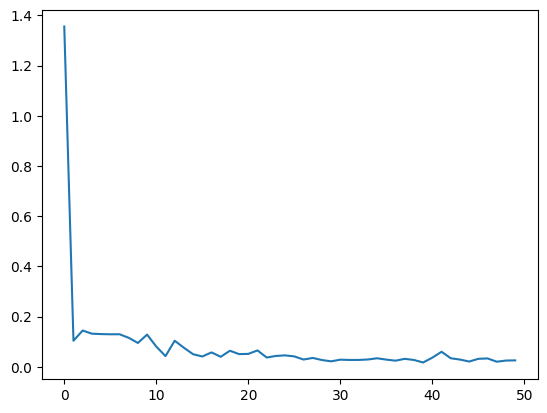

In [767]:
plt.plot(losses)

In [768]:
model[0].eval()

for batch,(data, target,idx) in enumerate(valid_dl):
    outputs = model[0](data)
    loss = criterion(outputs.reshape(-1), target.reshape(-1))
print(f"loss: {loss.item():>7f} ")

loss: 0.021988 


In [779]:
model[0].eval()
indexF=[]
indexT=[]
for i in range(len(trainset)):
    outputs = model[0](trainset.dataset.x[i])
    loss = criterion(outputs,trainset.dataset.y[i].reshape(1))
    if(loss>0.08):
        indexF.append(i)
    else:
        indexT.append(i)
        trainset.dataset.update_flag(i)

In [780]:
Fdataset=torch.utils.data.Subset(trainset, indexF)
Tdataset=torch.utils.data.Subset(trainset, indexT)
Fdl=DataLoader(Fdataset, shuffle=True, batch_size=batch_size)
Tdl=DataLoader(Tdataset, shuffle=True, batch_size=batch_size)


In [783]:
len(Fdataset)

585

In [784]:
class Decision(nn.Module):
    def __init__(self, input_dim, num_hidden1, num_hidden2,num_hidden3, output_dim):
        super().__init__()
        self.model=nn.Sequential(nn.Linear(input_dim,num_hidden1),
                                nn.Linear(num_hidden1,num_hidden2),
                                nn.Linear(num_hidden2,num_hidden3),
                                nn.Linear(num_hidden3,output_dim)
                                )
    def forward(self, x):
        return self.model(x)

In [785]:
model_decision=Decision(input_dim=2,num_hidden1=80,num_hidden2=128,num_hidden3=100,output_dim=2)
criterion_d = nn.CrossEntropyLoss()
optimizer_d= torch.optim.Adam(model_decision.parameters(), lr=0.001)

In [786]:
class Newdata(Dataset):
    def __init__(self,x,y):
        super().__init__()
        self.x=x
        self.y=torch.LongTensor(LabelEncoder().fit_transform(y))
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        data=self.x[idx]
        target=self.y[idx]
        return data,target


In [787]:
decisionset=Newdata(trainset.dataset.x,trainset.dataset.flag)
decision_dl=DataLoader(decisionset, shuffle=True, batch_size=batch_size)

In [794]:
#decision model train
num_epochs = 30
size = len(decision_dl)
model_decision.train()
for epoch in range(num_epochs):
    for batch,(data, target) in enumerate(decision_dl):
        outputs = model_decision(data)
        
        loss = criterion_d(outputs, target)
        optimizer_d.zero_grad()
        loss.backward()
        optimizer_d.step()
        
        if batch % 80 == 0: #每通過batch個數量的資料就輸出一次損失的值
            print(f"loss: {loss.item():>7f} ")
            losses.append(loss.item())

loss: 0.383106 
loss: 0.287597 
loss: 0.382473 
loss: 0.262256 
loss: 0.261396 
loss: 0.333763 
loss: 0.196947 
loss: 0.265573 
loss: 0.382633 
loss: 0.355428 
loss: 0.354783 
loss: 0.270953 
loss: 0.288752 
loss: 0.288929 
loss: 0.286596 
loss: 0.310832 
loss: 0.459382 
loss: 0.259839 
loss: 0.383187 
loss: 0.337682 
loss: 0.335005 
loss: 0.285847 
loss: 0.192738 
loss: 0.292262 
loss: 0.528873 
loss: 0.334590 
loss: 0.400327 
loss: 0.248292 
loss: 0.314726 
loss: 0.231510 
loss: 0.356891 
loss: 0.360304 
loss: 0.488922 
loss: 0.433440 
loss: 0.335540 
loss: 0.430935 
loss: 0.310773 
loss: 0.265197 
loss: 0.218011 
loss: 0.241696 
loss: 0.406913 
loss: 0.383637 
loss: 0.432024 
loss: 0.334597 
loss: 0.289403 
loss: 0.335787 
loss: 0.463711 
loss: 0.291327 
loss: 0.377218 
loss: 0.335300 
loss: 0.261276 
loss: 0.291039 
loss: 0.259902 
loss: 0.289827 
loss: 0.285660 
loss: 0.335594 
loss: 0.357433 
loss: 0.286312 
loss: 0.334408 
loss: 0.286429 


In [795]:
num_epochs = 80
size = len(Tdl)
model[1].train()
for epoch in range(num_epochs):
    for batch,(data, target,idx) in enumerate(Tdl):
        outputs = model[1](data)
        loss = criterion(outputs.reshape(-1), target.reshape(-1))
        optimizer[1].zero_grad()
        loss.backward()
        optimizer[1].step()
        if batch % 80 == 0: #每通過batch個數量的資料就輸出一次損失的值
            print(f"loss: {loss.item():>7f} ")
            losses.append(loss.item())

loss: 1.403926 
loss: 0.145117 
loss: 0.122063 
loss: 0.145248 
loss: 0.167777 
loss: 0.146081 
loss: 0.117421 
loss: 0.130672 
loss: 0.103916 
loss: 0.114915 
loss: 0.091051 
loss: 0.083840 
loss: 0.078059 
loss: 0.097304 
loss: 0.070772 
loss: 0.065781 
loss: 0.052548 
loss: 0.063790 
loss: 0.103071 
loss: 0.054051 
loss: 0.047498 
loss: 0.059645 
loss: 0.072323 
loss: 0.047457 
loss: 0.055061 
loss: 0.063629 
loss: 0.055575 
loss: 0.042559 
loss: 0.052892 
loss: 0.031534 
loss: 0.050874 
loss: 0.147829 
loss: 0.020177 
loss: 0.028691 
loss: 0.049284 
loss: 0.038876 
loss: 0.028600 
loss: 0.041120 
loss: 0.066758 
loss: 0.038351 
loss: 0.028430 
loss: 0.031321 
loss: 0.032435 
loss: 0.023078 
loss: 0.027784 
loss: 0.023815 
loss: 0.022945 
loss: 0.025141 
loss: 0.034551 
loss: 0.027743 
loss: 0.023385 
loss: 0.018576 
loss: 0.029349 
loss: 0.023937 
loss: 0.020400 
loss: 0.036497 
loss: 0.020416 
loss: 0.034967 
loss: 0.023428 
loss: 0.035070 
loss: 0.027262 
loss: 0.027681 
loss: 0.

In [796]:
num_epochs = 30
size = len(Fdl)
model[2].train()
for epoch in range(num_epochs):
    for batch,(data, target,idx) in enumerate(Fdl):
        outputs = model[2](data)
        loss = criterion(outputs.reshape(-1), target.reshape(-1))
        optimizer[2].zero_grad()
        loss.backward()
        optimizer[2].step()
        if batch % 80 == 0: #每通過batch個數量的資料就輸出一次損失的值
            print(f"loss: {loss.item():>7f} ")
            losses.append(loss.item())

loss: 1.218249 
loss: 0.172909 
loss: 0.152757 
loss: 0.183008 
loss: 0.146900 
loss: 0.141969 
loss: 0.159974 
loss: 0.134968 
loss: 0.156591 
loss: 0.125313 
loss: 0.150517 
loss: 0.143838 
loss: 0.140292 
loss: 0.149054 
loss: 0.145816 
loss: 0.136573 
loss: 0.171110 
loss: 0.180602 
loss: 0.145312 
loss: 0.149634 
loss: 0.140755 
loss: 0.154502 
loss: 0.150215 
loss: 0.147216 
loss: 0.162165 
loss: 0.151326 
loss: 0.143691 
loss: 0.153550 
loss: 0.125410 
loss: 0.132045 


In [ ]:
model[1].eval()

for batch,(data, target,idx) in enumerate(valid_dl):
    out = model_decision(data)
 
    _, y_pred_tag = torch.max(out, dim = 1)


    if(y_pred_tag==0):
        outputs=model[1](data)
    else:
        outputs=model[2](data)
    loss = criterion(outputs.reshape(-1), target.reshape(-1))
print(f"loss: {loss.item():>7f} ")

In [ ]:
model[1].eval()

for batch,(data, target,idx) in enumerate(valid_dl):
    outputs = model[1](data)
    loss = criterion(outputs.reshape(-1), target.reshape(-1))
print(f"loss: {loss.item():>7f} ")

loss: 0.028074 


In [ ]:
model[1].eval()
output=[]
for i in range(len(test_x)):
    output.append((model[1](test_x[i])).item())

In [ ]:
min(output)

0.3848611116409302

In [ ]:
sample_submission=pd.read_csv("C:/Users/MJ/Desktop/FunctionApproximation/sample_submission.csv")
sample_submission['y']=output
sample_submission.to_csv("C:/Users/MJ/Desktop/sample_submission.csv",index=False)